In [13]:
%matplotlib notebook
import amfe
import matplotlib.pyplot as plt
import numpy as np
from pyfeti import utils, linalg, feti_solver
from pyfeti import feti_solver as fetisolver
import pandas as pd
from scipy import sparse
import scipy

mshfile = r'..\mesh\full_2D_ring.inp'
m = amfe.Mesh()
m.import_inp(mshfile)



*************************************************************

Loading Abaqus-mesh from ..\mesh\full_2D_ring.inp
Can not read the given string list
WARNING! 2D case were selected
Mesh ..\mesh\full_2D_ring.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


In [14]:
m.get_phys_group_types()

{'DIRICHLET_ELSET', 'SURFACE_BODY_1_1_1D_ELSET', 'SURFACE_BODY_1_1_ELSET'}

In [15]:
m.change_tag_in_eldf('phys_group','DIRICHLET_ELSET',3)
m.change_tag_in_eldf('phys_group','SURFACE_BODY_1_1_ELSET',5)
m.change_tag_in_eldf('phys_group','SURFACE_BODY_1_1_1D_ELSET',4)



In [16]:
m.get_phys_group_types()

{3, 4, 5}

<IPython.core.display.Javascript object>


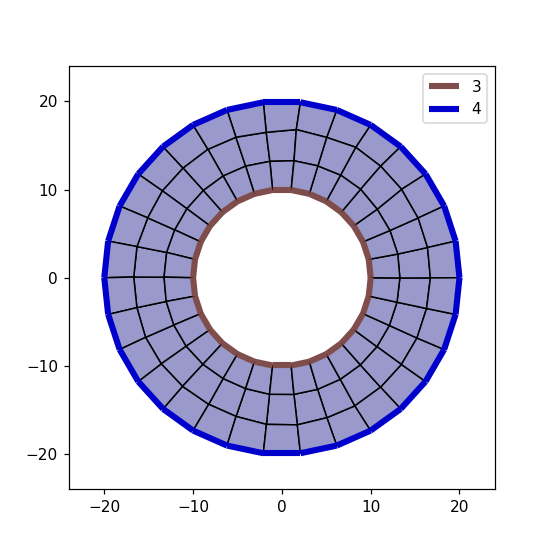

(-24.0, 24.0)

In [17]:
fig, ax1 = plt.subplots(figsize=(5,5))
amfe.plot2Dmesh(m,ax=ax1)
lim = 1.2*np.array([-20,20])
ax1.set_xlim(lim)
ax1.set_ylim(lim)

<IPython.core.display.Javascript object>


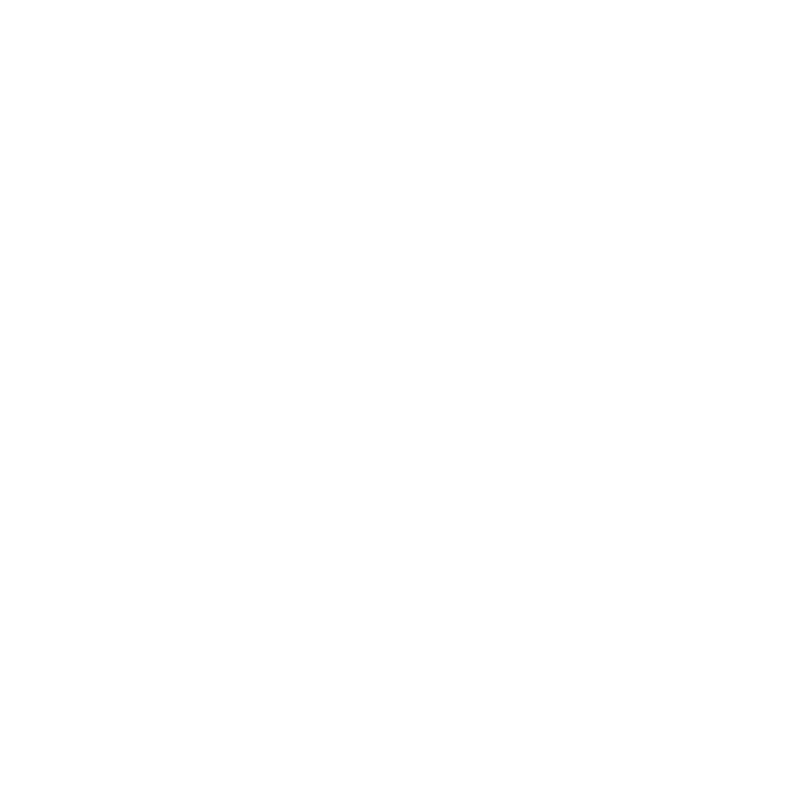

(-24.0, 24.0)

In [6]:
fig, ax2 = plt.subplots(figsize=(8,8))
amfe.plot2Dnodes(m,ax=ax2,plot_nodeid=True)
lim = 1.2*np.array([-20,20])
ax2.set_xlim(lim)
ax2.set_ylim(lim)

In [20]:
pd.DataFrame(m.nodes)

,0,1
0,20.000000,-8.277685e-15
1,19.562952,4.158234e+00
2,18.270908,8.134733e+00
3,16.180340,1.175570e+01
4,13.382612,1.486290e+01
5,10.000000,1.732051e+01
6,6.180340,1.902113e+01
7,2.090569,1.989044e+01
8,-2.090569,1.989044e+01
9,-6.180340,1.902113e+01


In [7]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(5,my_material)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 90 elements and 240 dofs.
Time taken for preallocation: 0.00 seconds.


In [8]:
id_matrix = my_comp.assembly_class.id_matrix
id_map_df = utils.dict2dfmap(id_matrix )

group_dict = utils.OrderedDict()

m.split_in_groups()
node_set_3 = m.groups[3].global_node_list # Dirichlet

manager_obj = utils. DofManager(id_map_df)

group_dict = utils.OrderedDict()
group_dict['Dirichlet'] = utils.OrderedSet(manager_obj.get(node_set_3,'xy'))

s = utils.SelectionOperator(group_dict, id_map_df)


In [9]:
# assembling sector matrices
K1, f = my_comp.assembly_class.assemble_k_and_f()
M1 = my_comp.assembly_class.assemble_m()

K1d, sred = s.assemble_matrix(K1.toarray(),['internal'],True)
M1d, sred = s.assemble_matrix(M1.toarray(),['internal'],True)



In [10]:
w, v = scipy.linalg.eig(K1d.toarray(),M1d.toarray())

np.sort(np.sqrt(w.real))/(2.0*np.pi)


array([  51.33701875,   67.69987655,   67.70181073,   98.95552802,
         98.96640699,  124.59940206,  124.60432112,  139.89503741,
        140.20928253,  140.22626052,  144.19288083,  144.22255155,
        145.96863183,  146.00781069,  166.82364467,  166.85278177,
        168.9271251 ,  168.95565454,  194.38444851,  194.49263414,
        208.08098336,  208.14264578,  226.53892969,  226.80801745,
        253.39008028,  253.47975678,  260.2661946 ,  262.75225952,
        263.17256524,  269.11938459,  269.18534262,  293.3093994 ,
        293.37809591,  301.60308901,  302.0164785 ,  302.50704044,
        302.87291512,  328.59917776,  328.68728042,  344.63521053,
        345.04520439,  352.45510255,  353.04099395,  372.06195575,
        372.14296187,  387.3879392 ,  388.34873359,  405.66334935,
        406.44638352,  421.58695191,  421.72087434,  428.62625361,
        429.34223555,  444.52685357,  445.21086851,  446.26472996,
        446.58688043,  449.10203481,  449.39612517,  450.47963

<IPython.core.display.Javascript object>


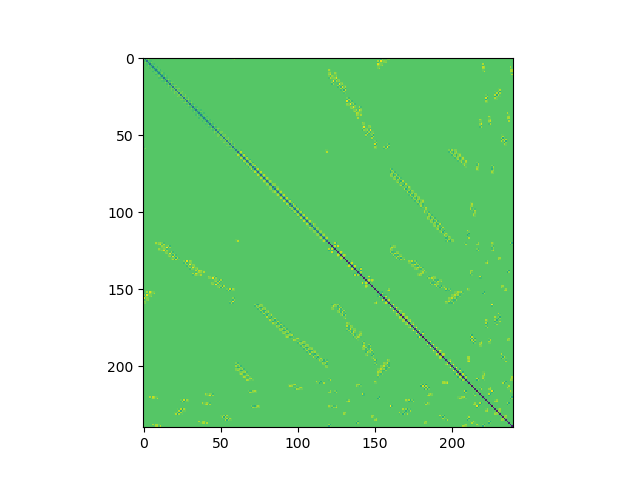

In [11]:
%matplotlib notebook
plt.imshow(K1.toarray())
plt.show()

In [18]:
K1d

<180x180 sparse matrix of type '<class 'numpy.float64'>'
	with 2520 stored elements in Compressed Sparse Column format>